In [5]:
name = "2020-08-06-pyproj"
title = "Making a geographic grid with pyproj"
tags = "matplotlib, cartopy, dataviz, maps, CRS"
author = "Callum Rollo"

In [6]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags, author)

In [1]:
import cartopy
import cartopy.crs as ccrs
import geopy
import matplotlib.pyplot as plt
import numpy as np

The aim of this notebook is to create a spatial grid of uniform spacing from a user defined origin point

Along the way I will introudice some functionality of geopy, cartopy and pyproj, as well as a brief discussion on map projections in general

To go from lon/lat to x/y we first need to define an origin. That is a geographical location that will be the center of our x,y grid. Let's pick Norwich, a fine city.

In [2]:
origin = (1.297, 52.630)

In [3]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k', facecolor='palegreen')

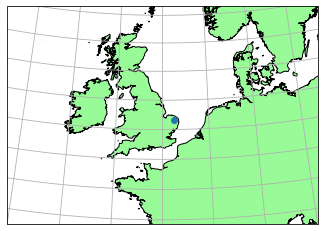

In [4]:
ax = plt.axes(projection=ccrs.AlbersEqualArea()) # note the use of an equal-area projection
ax.add_feature(land_10m, zorder=-1)
ax.scatter(origin[0], origin[1], transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False)
ax.set_extent([-15, 15, 45, 60], crs=ccrs.PlateCarree());

**NB** that many modules, geopy included expect arguments to be passed in order (lat, lon). For this notebook, I am keeping data in format (lon,lat) to be consistent with the (x,y) of the cartesian grid we will create

### Naive approach: make a grid of lon/lat

In [5]:
grid_lons = np.arange(origin[0]-30,origin[0]+30,4)
grid_lats = np.arange(origin[1]-30,origin[1]+30,4)

In [7]:
# Make a chequerboard grid for plotting
grid_val = np.empty((len(grid_lats),len(grid_lons)))
grid_val[:] = 0
grid_val[1::2,::2] = 1
grid_val[::2,1::2]= 1
grid_val

array([[0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0.

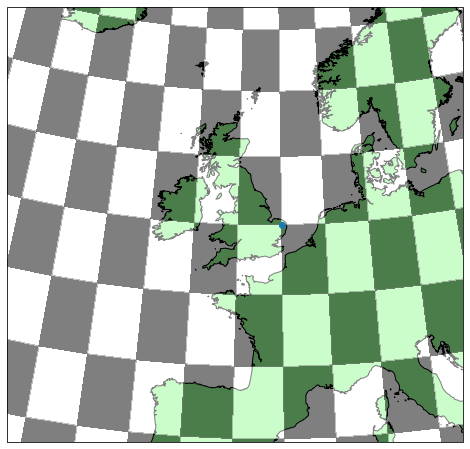

In [8]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.AlbersEqualArea()) # note the use of an equal-area projection
ax.add_feature(land_10m, zorder=-1)
ax.scatter(origin[0], origin[1], transform=ccrs.PlateCarree(), zorder=2)
#l = ax.gridlines(draw_labels=False)
ax.pcolor(grid_lons, grid_lats, grid_val, transform=ccrs.PlateCarree(), alpha=0.5, cmap='Greys', shading='auto', zorder=1)
ax.set_extent([-20, 15, 40, 65], crs=ccrs.PlateCarree());

We can see that the width of the grid cells decreases toward the pole, not ideal if we want something equal area. 

(It also makes Europe look like a [ska band logo](https://duckduckgo.com/?q=ska+band+logo&t=lm&iar=images&iax=images&ia=images), and [no-one wants that](https://thehardtimes.net/music/doomsday-preppers-ready-fourth-wave-ska/))

Instead. **lets try making an equally spaced grid in x-y space then convert it to lon-lat**

This turns out to be a non-trivial problem. There is a lot of [discussion](https://stackoverflow.com/questions/24427828/calculate-point-based-on-distance-and-direction) [on the internet](https://stackoverflow.com/questions/33001420/find-destination-coordinates-given-starting-coordinates-bearing-and-distance) about how to do this

While calculating the distance between two geographic points has a well determined solution in the [Haversine formula](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points/4913653#4913653). The inverse challenge, to find a second lon,lat point from an initial lon,lat, a distance and a bearing, is a thornier problem.

geopy.distance provides a solution

In [9]:
from geopy import distance

# Define starting point.
start = geopy.Point(origin[1], origin[0]) # remember geopy expects (lat, lon)

# Define a general distance object
d = distance.distance(kilometers=200)

# Use the `destination` method with a bearing of 0 degrees (which is north)
# in order to go from point `start` 200 km to the north.
final = d.destination(point=start, bearing=0)

In [11]:
print(start)
print(final)
print(f"distance between points {distance.distance(start, final)}")

52 37m 48s N, 1 17m 49.2s E
54 25m 37.2254s N, 1 17m 49.2s E
distance between points 200.00000000000014 km


We have made a point 200 km north without moving east. So far so good. Let's try going round in a "square"




In [12]:
locations = [start] # Use Norwich as our start
locations.append(d.destination(point=locations[-1], bearing=0))   # 200 km N
locations.append(d.destination(point=locations[-1], bearing=90))  # 200 km E
locations.append(d.destination(point=locations[-1], bearing=180)) # 200 lm S
locations.append(d.destination(point=locations[-1], bearing=270)) # 200 km W

In [13]:
locations

[Point(52.63, 1.297, 0.0),
 Point(54.42700705782743, 1.297, 0.0),
 Point(54.38772925591396, 4.376566067739076, 0.0),
 Point(52.59071031826249, 4.376566067739076, 0.0),
 Point(52.5539623252431, 1.4270689309287699, 0.0)]

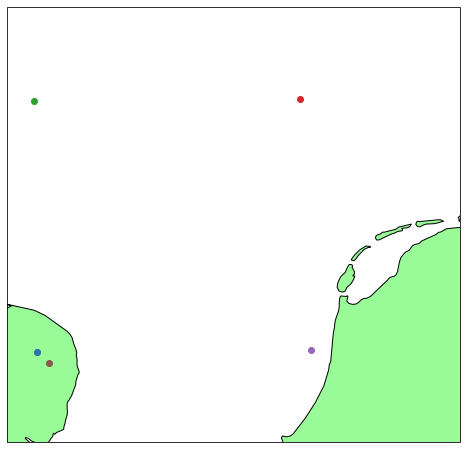

In [14]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.AlbersEqualArea()) 
ax.add_feature(land_10m, zorder=-1)
ax.scatter(origin[0], origin[1], transform=ccrs.PlateCarree(), zorder=2)
ax.set_extent([1, 6, 52, 55], crs=ccrs.PlateCarree());
for p in locations:
    ax.scatter(p.longitude, p.latitude, transform=ccrs.PlateCarree())

**The start and end points do not match!**

We cannot simply make a grid by moving a set distance in cardinal directions. This is explored elegantly in the classic [Martin Gardner puzzle](https://gdaymath.com/lessons/gmp/1-6-its-all-a-lie-well-sort-of/)

This is because the Earth is not flat[1]</sup>

[[1](https://i0.kym-cdn.com/entries/icons/facebook/000/001/865/wikipedian_protester.jpg)] Trust me on this, or the rest of the notebook is gonna be a struggle

### What is to be done? We need our grid!

A better approach is to use a coordinate reference system (CRS) by cartographic projection. If you have used Cartopy before you will have encountered these already via the `cartopy.crs` module. You can see examples of Cartopy in use earlier in this notebook. For a quick refresher, check out the [cartopy notebook from the Aries/Cefas Python course](https://github.com/ueapy/pythoncourse2020-materials/blob/master/notebooks/18-Cartopy-Intro.ipynb)

If we wish to transform coordinates and perform calculations on our data and no immediately plot them on a map, we need **pyproj**



# Pyproj

[pyproj](https://pyproj4.github.io/pyproj/stable/) is a Python wrapper around [PROJ](https://proj.org/), the definitive tool for CRSs and their transformations.

What we want to do here is take coordinates in lon and lat, convert them to a local grid in m or km and convert back again.

pyproj is an extremely powerful module, but not the most user friendly module. Here I will attempt to demostrate some of its core functionality. 

In [15]:
from pyproj import CRS
from pyproj import Transformer

There are [1000s of projections](https://www.spatialreference.org/ref/epsg/), it can be very bewildering at first. Before diving in, we need to define our starting point, what coordinate reference system are our data in?

Most likely we have coordinates in lon/lat, references to the WGS84 datum the [WGS84](https://epsg.io/4326) reference system. This is used by satellite navigation systems and it's a pretty good bet your lon-lat are references to WGS84 We find its [EPSG code](https://epsg.io/4326) and check it with pyproj.

If you location data are in some more esoteric form, like Ordnance Survey grid references, pyproj can handle that too.

In [16]:
crs = CRS.from_epsg(4326)
crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We see that WGS84 defines lat and lon in degrees east and north, valid for the whole Earth.

-------------

Now we need a CRS to transform **to**. A generally good choice is the popular [universal transverse mercator](https://proj.org/operations/projections/utm.html?highlight=transverse%20mercator) (UTM)

This is in fact a family of 60 projections, each adapted to a 6 degree wide strip

Here I have made a short function to find the most suitable UTM for the area we wish to plot

In [17]:
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

In [19]:
local_utm = CRS.from_proj4(utm_zoner(2,52))
local_utm

<Projected CRS: +proj=utm +zone=31 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

####  For Norwich, this is UTM zone 31, as should be clear from the map

![UTM zones](https://proj.org/_images/utm_zones.png)

If in doubt, you can recover the EPSG code of your projection and serach it on [epsg.io](https://epsg.io/)

In [20]:
local_utm.to_epsg()

32631

Now that we have defined our two coordinate reference systems, we make functions to transform between the two. Here I use the postscripts `to_m` to indicate transorm to meters in UTM and `to_deg` to transform back to degrees in WGS84

In [22]:
trans_to_m = Transformer.from_crs("EPSG:4326", local_utm, always_xy=True)
trans_to_deg = Transformer.from_crs(local_utm, "EPSG:4326", always_xy=True)

**NB** We had to define both the origin and desination CRS for this as it is a transform. You can make arbitrary transforms betwwen various difference CRSs

Using `always_xy=True` ensures that these functions always take and return coordinates easting first (lon, lat or x,y), regardless of the formal definition of the CRS

First, lets find the x,y coordinates of our origin, the fine city

In [23]:
origin_m = trans_to_m.transform(*origin)
origin_m

(384740.87024377135, 5832473.856915312)

Now, we make a grid with origin at its center, I have a chosen a step size of 50 km. You will have seen that the UTM defines easting and northing in meters, some coordinate reference systems use km, miles (imperial or nautical) or even feet. Always check!

In [24]:
step = 50 * 1000 # A step of 50 km

x_grid = np.arange(origin_m[0]-5*step, origin_m[0]+ 6*step, step) # an x grid with 5 points west of center and five points east
y_grid = np.arange(origin_m[1]-5*step, origin_m[1]+ 6*step, step) # a y grid with 5 points south of center and five points north
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

Sanity check to make sure we have a regularly spaced grid

In [25]:
x_grid[1:] - x_grid[:-1]

array([50000., 50000., 50000., 50000., 50000., 50000., 50000., 50000.,
       50000., 50000.])

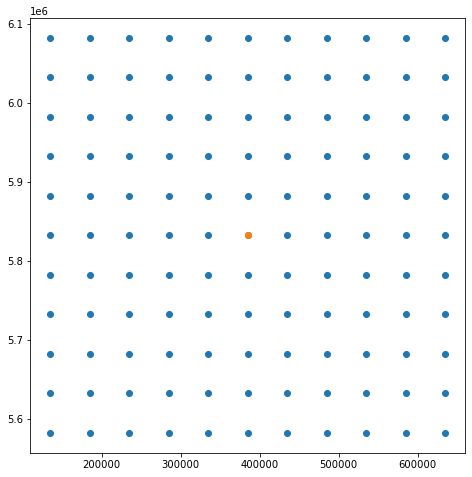

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x_mesh, y_mesh)
ax.scatter(*origin_m)
ax.set_aspect('equal', adjustable='box')

We transform these grids of x and y into lon and lat

In [27]:
lon_mesh, lat_mesh = trans_to_deg.transform(x_mesh,y_mesh)

We did it! Let's see what we've made

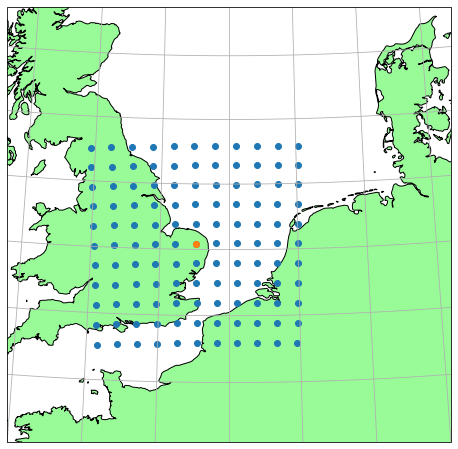

In [28]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=2.5, central_latitude=53)) # note the use of an equal-area projection
ax.add_feature(land_10m, zorder=-1)
gl = ax.gridlines(draw_labels=False)
ax.scatter(lon_mesh, lat_mesh, transform=ccrs.PlateCarree() )
ax.scatter(origin[0], origin[1], transform=ccrs.PlateCarree(), zorder=5)
ax.set_extent([-5, 10, 48, 58], crs=ccrs.PlateCarree());

### Behold our beautiful grid

It looks a little off-kilter as it does not align with the lon-lat graticle. This is a Good Thing for reasons outlined above

#### Looks cool, but how do we check the distance between those points?

We'll use the geopy's distance to meausure the x and y distances between adjacent points

In [29]:
x_dists = []
y_dists = []

for i in range(10):
    for j in range(10):
        x_dists.append(distance.distance((lat_mesh[i,j], lon_mesh[i,j]), (lat_mesh[i,j], lon_mesh[i,j+1])).km)
        y_dists.append(distance.distance((lat_mesh[i,j], lon_mesh[i,j]), (lat_mesh[i+1,j], lon_mesh[i,j])).km)

In [30]:
print(f"x mean distance {np.round(np.mean(x_dists),2)} km, standard deviation {np.round(np.std(x_dists),3)} km")
print(f"y mean distance {np.round(np.mean(y_dists),2)} km, standard deviation {np.round(np.std(y_dists),3)} km")

x mean distance 49.97 km, standard deviation 0.056 km
y mean distance 49.95 km, standard deviation 0.074 km


[Text(0.5, 0, 'y grid spacing (km)')]

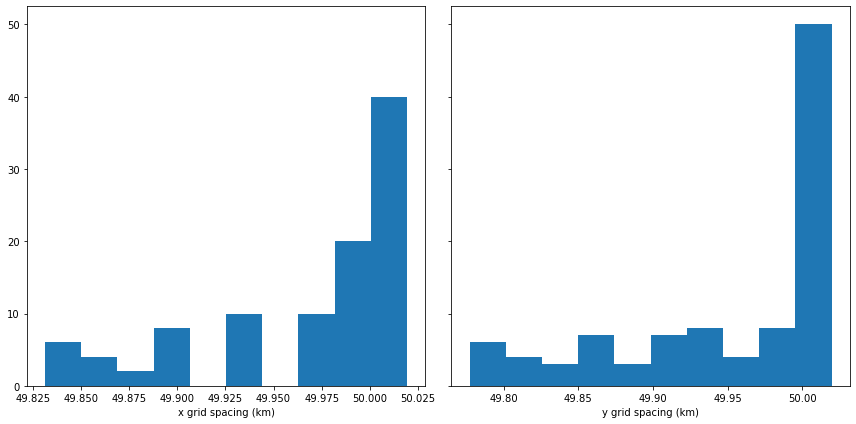

In [31]:
n_bins = 10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(12,6))

axs[0].hist(x_dists, bins=n_bins)
axs[1].hist(y_dists, bins=n_bins)
axs[0].set(xlabel='x grid spacing (km)')
axs[1].set(xlabel='y grid spacing (km)')

As we see **there will always be distortion** trying to make a cartesian grid on a curved surface. (especially when Earth is [not even close to a perfect sphere](https://www.scientificamerican.com/article/earth-is-not-round/)

In this case the distortion is ~ 0.1 % over a spacial extent of 500 * 500 km. Not bad.

Why not experiment with some other CRS and see how close you can get to a perfect grid?

Experiment with pyproj and cartopy. Both have tutorials on their websites, checkout out Cartopy's great [example gallery](https://scitools.org.uk/cartopy/docs/latest/gallery/index.html) for some cartographic inspiration.

Most importantly, remember that your prefered map projection says something about you

![xkcd.com/977](https://imgs.xkcd.com/comics/map_projections.png)

In [7]:
HTML(html)